# Zillow Predictions

by Mathias Boissevain 2022-03-30

## Project Goal

The goal of this project is to gain insight on how to improve models that predict the property tax assessed values of Single Family Properties that had a transaciton in 2017.

## Project Description

Providing acurrate data to our customer base is of upmost importance. Here at Zillow we pride ourselves in consistant improvement. Imporving our predictive models can help us keep an edge in this highly competitive online space. In this project I will explore what features we can use to improve our current models to predict tax assessed values of Single Family Properties that had a transaction in 2017.

## Intial Questions

- Does county affect price?
- Does the size of the house (area) affect price?
- Does the age affect price?
- Does the number of bedrooms or bathrooms affect price.

## Data Dictionary

Variable | Meaning |
:-: | :-- |
'bathrooms'|Number of bathrooms in home including fractional bathrooms
'bedrooms'|Number of bedrooms in home 
'bed_to_bath_ratio'|Bedrooms divided by Bathrooms
'area'|Calculated total finished living area of the home 
'county'|county where home was sold
'parcelid'|Unique identifier for parcels (lots) 
'propertylandusetypeid'|Type of land use the property is zoned for
'yearbuilt'|The Year the principal residence was built 
'taxvaluedollarcnt'|The total tax assessed value of the parcel
'taxable_value'|The total tax assessed value of the parcel

## Wrangle Zillow Data

The Codeup mySQL server was used to retrieve the zillow dataset using the following query:

'''
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, fips

FROM properties_2017

JOIN predictions_2017
USING(parcelid)

JOIN propertylandusetype
USING(propertylandusetypeid)

WHERE propertylandusetypeid = 261
'''

In [1]:
# Import wrangle module for acquistion and processing
import wrangle

# Import warning to stop unneeded warning messages
import warnings
warnings.filterwarnings('ignore')

The data was prepared in the following steps:

1) Features were renamed for usability

2) New features were created. 

    - house_age_2017 == 2017 - year_built
    - bed_to_bath_ratio == bedrooms / bathrooms


3) When creating the bed_to_bath_ratio we divided by zero and ended up creating a few infinite values so those we changed to null values.

4) Nulls were then dropped

5) fips has been renamed county and here we assigned the county name to thier respective county name.

6) Dummy variables were created for county variables and then added to the dataframe

7) Outliers were removed

8) The data was then split for modeling

In [2]:
# Acquire and Prepare data
train, validate, test = wrangle.wrangle_zillow()

Using cached csv file...


Our data is split into 3 samples:

- The train sample represents 56 % of the data and is used to train the model
- The validate sample represents 24 % of the data and is used to test for overfitting
- The test sample reresents 20 % of the data and is used to test our top model
- All splits were done with a seed of 1729

In [3]:
# Assign X for testing the model, y as target for modeling

X_train, y_train = wrangle.model_split(train)
X_validate, y_validate = wrangle.model_split(validate)
X_test, y_test = wrangle.model_split(test)

Our train, validate and test sets were further split into:
- X: Data used for modeling that does not contain the target variable
- y: The target variable that our models will be trained to predict

In [4]:
# Scale the appropriate values for train, validate and test

X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.scale_data(X_train,X_validate,X_test)

## Data Context

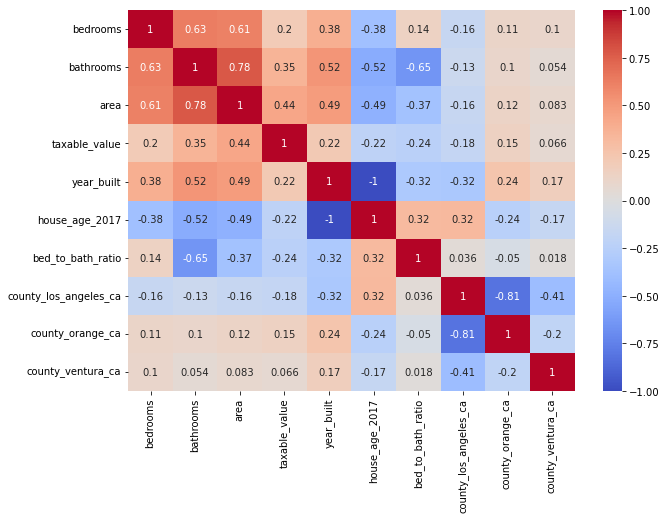

In [5]:
# Import for visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Perform a Pearson Correlation on the dataset
plt.figure(figsize=(10,7))
correlate = train.corr()
# Plot the Correlation on a heatmap
sns.heatmap(correlate, annot=True, cmap='coolwarm')
plt.show()

## Exploratory Data Analysis

**1. Does county affect price?**

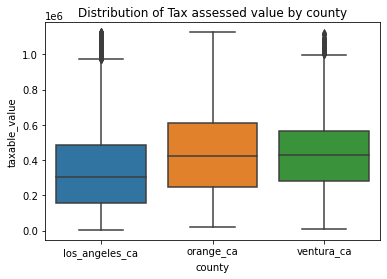

In [6]:
sns.boxplot('county','taxable_value',data=train)
plt.title('Distribution of Tax assessed value by county')
plt.show()

**Summary**: County does seem to affect the taxable_value a bit. Orange county has the highest mean, while Los Angeles County has the lowest.

**2. Does the size of the house (area) affect price?**

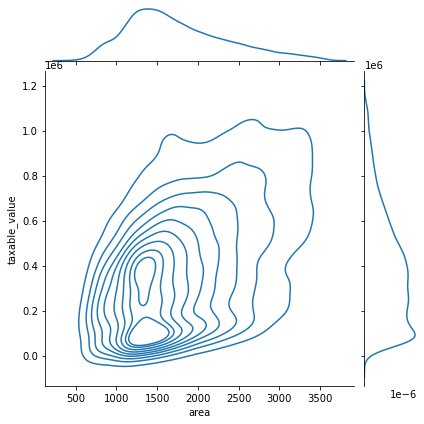

In [8]:
sns.jointplot(x='area', y='taxable_value', data=train, kind='kde')
plt.show()

**Hypothesis**:
- $H_0$: There is no linear correlation between the finished house size and taxable_value.
- $H_α$: There is a linear correlation between the finished house size and taxable_value.

In [22]:
# Import scipy.stats to access correlation test
from scipy import stats
# Pearson's r Correlation Test
# Assign α
α = 0.5
# Run Correlation test
corr, p = stats.pearsonr(train.area,train.taxable_value)
# Assess p value and decided on hypothesis to be kept
if p < α:
    print('Reject Null Hypothesis')
else: 
    print('Do not reject Null Hypothesis')

Reject Null Hypothesis


**Summary**: The plot above shows a potential for the size of the house or area having a positive affect on the housing price. Our correlation test does show that there is a correlation between the two variables.

**3. Does the age affect price?**

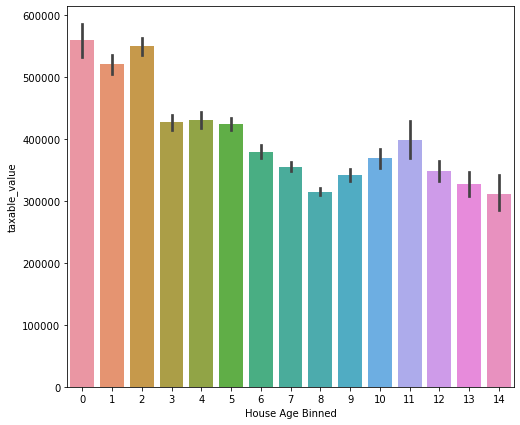

In [10]:
# import pandas for binning data
import pandas as pd
# Make copy to bin
train_age = train.copy()
# Bin data
train_age['house_age_2017'] = pd.cut(train_age.house_age_2017, 15,labels=False)
# Set size
plt.figure(figsize=(8,7))
# barplot
sns.barplot(x='house_age_2017', y='taxable_value', data=train_age)
plt.xlabel('House Age Binned')
plt.show()

**Hypothesis**:
- $H_0$: There is no linear correlation between the house age and taxable_value.
- $H_α$: There is a linear correlation between the house age and taxable_value.

In [23]:
# Pearson's r Correlation Test
# Assign α
α = 0.5
# Run Correlation test
corr, p = stats.pearsonr(train.house_age_2017,train.taxable_value)
# Assess p value and decided on hypothesis to be kept
if p < α:
    print('Reject Null Hypothesis')
else: 
    print('Do not reject Null Hypothesis')

Reject Null Hypothesis


**Summary**: The plot above shows a drop in taxable_value as the age of the house rises.

**4. Does the number of bedrooms or bathrooms affect price?**

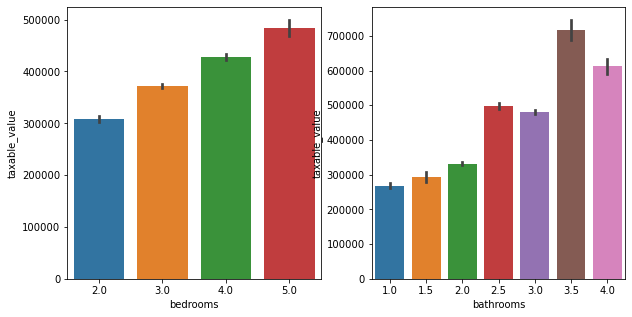

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.barplot(x='bedrooms', y='taxable_value', data=train, ax=ax[0])
sns.barplot(x='bathrooms', y='taxable_value', data=train, ax=ax[1])
plt.show()

**Summary**: As the count of both bedrooms and bathrooms rise the taxable_value also seems to rise. With some notable differences in the mid to upper range of bathrooms. The half baths seem to have a larger affect than the whole baths. Futher exploration is needed.

### Recursive Feature Elimination

In [26]:
# Import RFE from Sklearn
from sklearn.feature_selection import RFE

# initialize Linear Regression model
lm = LinearRegression()

# Create Recursive Feature Elimination model
rfe = RFE(lm, n_features_to_select=3)

# fit the model
rfe.fit(X_train_scaled, y_train)

# get mask of columns selected
feature_mask = rfe.support_

# get list of selected column names
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

# Create list of variables and their ranking

# ranks
var_ranks = rfe.ranking_

# names
var_names = X_train_scaled.columns.tolist()

# combine to dataframe
rfe_ranks_df = pd.DataFrame({'Variable' : var_names, 'Rank' : var_ranks})

# sort
rfe_ranks_df.sort_values('Rank')

,Variable,Rank
2,area,1
3,year_built,1
4,house_age_2017,1
0,bedrooms,2
1,bathrooms,3
5,bed_to_bath_ratio,4


**Exploration Summary**: It does look as though the variables explored show potential for affecting our models. With county and age showing a slight affect and area and bedrooms and bathrooms showing a larger affect. After running through the process of Recursiv Feature Elimination we see that area and year_built show the highest performance in this model.

## Model

**Features:** Running through the models area was paired with original features as well as newly seperated features to see if there was any improvement.

### Baseline

In [14]:
# Import models
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

# Import for model evaluation
from sklearn.metrics import mean_squared_error

In [15]:
# Predict taxable_value_pred_mean
taxable_value_pred_mean = y_train['taxable_value'].mean()
y_train['taxable_value_pred_mean'] = taxable_value_pred_mean
y_validate['taxable_value_pred_mean'] = taxable_value_pred_mean

# RMSE of taxable_value_pred_mean
rmse_train = mean_squared_error(y_train.taxable_value, y_train.taxable_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.taxable_value_pred_mean)**(1/2)

print("RMSE Baseline using Mean\nTrain(In-Sample): ", round(rmse_train, 2), 
      "\nValidate(Out-of-Sample): ", round(rmse_validate, 2))

RMSE Baseline using Mean
Train(In-Sample):  245412.89 
Validate(Out-of-Sample):  247632.63


- Mean of taxable_value was used as a baseline as it performed better than the median.

### Evaluation Metric

- Root Mean Squared Error was used as the evaluation meteric for this project. This gives us our value error in dollars which helps us understand how far off our models are.

### Models

- Out of all the models run the following were the top 3 performers.

### Lasso Lars Model

In [16]:
# create the model object 
lars = LassoLars(alpha=1.0)

# fit the model 
lars.fit(X_train_scaled[['area','bedrooms','bathrooms','year_built']], y_train.taxable_value)

# predict train
y_train['taxable_value_pred_lars'] = lars.predict(X_train_scaled[['area','bedrooms','bathrooms','year_built']])

# evaluate: rmse_train
rmse_train = mean_squared_error(y_train.taxable_value, y_train.taxable_value_pred_lars)**(1/2)

# predict validate
y_validate['taxable_value_pred_lars'] = lars.predict(X_validate_scaled[['area','bedrooms','bathrooms','year_built']])

# evaluate: rmse_validate
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.taxable_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining(In-Sample): ", rmse_train, 
      "\nValidation(Out-of-Sample): ", rmse_validate)

RMSE for Lasso + Lars
Training(In-Sample):  219292.4882450899 
Validation(Out-of-Sample):  220904.9676822525


- The Lasso Lars model fell off a bit on the validation set potentially showing overfitting.

### Linear Regression Model

In [17]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model
lm.fit(X_train_scaled[['area','bedrooms','bathrooms','year_built']], y_train.taxable_value)

# predict train
y_train['taxable_value_pred_lm'] = lm.predict(X_train_scaled[['area','bedrooms','bathrooms','year_built']])

# evaluate: rmse_train
rmse_train = mean_squared_error(y_train.taxable_value, y_train.taxable_value_pred_lm)**(1/2)

# predict validate
y_validate['taxable_value_pred_lm'] = lm.predict(X_validate_scaled[['area','bedrooms','bathrooms','year_built']])

# evaluate: rmse_validate
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.taxable_value_pred_lm)**(1/2)

print("RMSE for Ordinary Least Squares using LinearRegression\nTraining(In-Sample): ", rmse_train, 
      "\nValidation(Out-of-Sample): ", rmse_validate)

RMSE for Ordinary Least Squares using LinearRegression
Training(In-Sample):  219292.13875983964 
Validation(Out-of-Sample):  220905.6652927631


- The Linear Regression Model preformed very similar to the Lasso Lars model

### Polynomial Regression Model

In [18]:
# make the polynomial features 
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[['area','bedrooms','bathrooms','year_built']])

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled[['area','bedrooms','bathrooms','year_built']])
X_test_degree2 = pf.transform(X_test_scaled[['area','bedrooms','bathrooms','year_built']])

In [19]:
# create the model
plm = LinearRegression(normalize=True)

# fit the model
plm.fit(X_train_degree2, y_train.taxable_value)

# predict train
y_train['taxable_value_pred_plm'] = plm.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxable_value, y_train.taxable_value_pred_plm)**(1/2)

# predict validate
y_validate['taxable_value_pred_plm'] = plm.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.taxable_value_pred_plm)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining(In-Sample): ", rmse_train, 
      "\nValidation(Out-of-Sample): ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training(In-Sample):  218289.83036623642 
Validation(Out-of-Sample):  220025.56808972612


In [20]:
# predict on test
y_test['taxable_value_pred_plm'] = plm.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxable_value, y_test.taxable_value_pred_plm)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest(Out-of-Sample): ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test(Out-of-Sample):  218904.64295019858


- The Polynomial Regression model ran the best and performed the best on test data with a RMSE of 218,904.64 dollars which is 26,508.25 dollars better than the baseline RMSE ran on train.

### Conclusion

#### Summary

- In exploration we saw that area and year_built were good indicators of taxable_value. While bathrooms performed better both bathroom and bedroom count also showed promise.
- In the modeling phase the top performers all had the original features so the newly created features could be dropped or reassesed as they did not show significant improvment.

#### Recommendations

Moving forward more needs to be done to improve our models as a 200,000 dollar plus error is a big deal.

#### Next Steps

Given more time more I would like to assess the features further to maximize feature engineering. As well as assess the dropped values and outliers to potential keep more data for modeling. 